Credits/Course URL: https://www.udemy.com/course/machinelearning/

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import spacy
import en_core_web_sm
from nltk.corpus import stopwords
from slugify import Slugify
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from mlxtend.plotting import plot_decision_regions

In [14]:
#nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Luvkush\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

#### Reading the data

In [7]:
data = pd.read_csv(r'E:\Github\Datasets\Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)
data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


#### Data Exploration

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


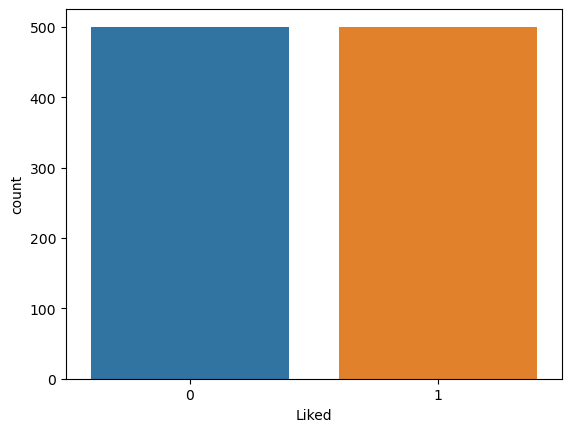

In [10]:
sns.countplot(x = 'Liked', data = data);

#### Data Cleaning

In [25]:
def preprocess_lemma(sentence):
    nlp = spacy.load('en_core_web_sm')
    tokens = [tok.lemma_ for tok in nlp(sentence)]
    tokens = ' '.join(tokens)
    return tokens

In [53]:
def preprocess(sentence):
    
    sentence = sentence.lower()    
    sentence = re.sub(r"https?://[A-Za-z0-9/.-]+", ' ', sentence) # Remove URLs
    custom_slugify = Slugify(to_lower = True, 
                         separator = ' ',
                         safe_chars = '@')
    
    sentence = custom_slugify(sentence) # slugified the sentence
    sentence = re.sub(r"@[A-Za-z0-9]+", '', sentence) # removing twitter username
    sentence = re.sub(r"[0-9]+[A-Za-z]+", '', sentence) # removing strings starting with numbers in the string
    sentence = re.sub(r"[0-9]+", '', sentence) # removing numbers in the string
    sentence = re.sub(r'((\w)\2{2,})', '', sentence) # Repeated words removed
    sentence = re.sub('[^a-zA-z]', ' ', sentence) # remove everything except alphabets
    
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    all_stopwords = set(all_stopwords)
    
    nlp = spacy.load('en_core_web_sm')
    
    tokens = [token.text for token in nlp(sentence) if not (token.is_punct or token.is_space or len(token) == 1)]
    tokens = [word for word in tokens if not word in all_stopwords]
    tokens = ' '.join(tokens)
    tokens = preprocess_lemma(tokens)
    
    return tokens

In [54]:
corpus = data['Review'].head(250).apply(lambda x: preprocess(x))

In [57]:
corpus2 = data['Review'].iloc[250:751].apply(lambda x: preprocess(x))

In [58]:
corpus3 = data['Review'].iloc[751:].apply(lambda x: preprocess(x))

In [60]:
corpus_cleaned = pd.concat([corpus, corpus2, corpus3], ignore_index= True)

#### Creating bag of words

In [71]:
count_vectorizer = CountVectorizer(max_features=1600)

In [72]:
X = count_vectorizer.fit_transform(corpus_cleaned).toarray()
y = data['Liked'].values

In [73]:
X.shape[1]

1600

In [75]:
X.shape, y.shape

((1000, 1600), (1000,))

#### Splitting the data

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [77]:
X_train.shape, y_train.shape

((700, 1600), (700,))

In [78]:
X_test.shape, y_test.shape

((300, 1600), (300,))

#### Running appropriate (multiple) Classification Models on the Data to determine the best model

In [79]:
# custom function which accepts the ML model and the spittled data, and returns the training and testing accuracy
# this fuction is quick way to getting the accuracies, just by creating the model and passing it with the data to this function

def ML_model_classifier(model, X_train, X_test, y_train, y_test, verbose=0):
    
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    train_acc = round((accuracy_score(y_train, y_pred_train)*100),2)
    test_acc = round((accuracy_score(y_test, y_pred_test)*100),2)
    
    if verbose:
        print(f'Model: {model}')
        print(f'Training Accuracy: {train_acc}%')
        print(f'Test Accuracy: {test_acc}%')
    
    return model, train_acc, test_acc

In [86]:
# Running the data with LogisticRegression

clf = LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)
model, train_acc, test_acc = ML_model_classifier(clf, X_train, X_test, y_train, y_test, verbose = 1)

Model: LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)
Training Accuracy: 88.29%
Test Accuracy: 75.0%


In [87]:
# Running the data with DecisionTreeClassifier

clf = DecisionTreeClassifier(class_weight='balanced')
model, train_acc, test_acc = ML_model_classifier(clf, X_train, X_test, y_train, y_test, verbose = 1)

Model: DecisionTreeClassifier(class_weight='balanced')
Training Accuracy: 100.0%
Test Accuracy: 76.33%


In [88]:
# Running the data with RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, class_weight='balanced')
model, train_acc, test_acc = ML_model_classifier(clf, X_train, X_test, y_train, y_test, verbose = 1)

Model: RandomForestClassifier(class_weight='balanced', n_estimators=200)
Training Accuracy: 100.0%
Test Accuracy: 80.67%


In [89]:
# Running the data with SVC

clf = SVC(kernel = 'linear',gamma = 'scale', shrinking = False)
model, train_acc, test_acc = ML_model_classifier(clf, X_train, X_test, y_train, y_test, verbose = 1)

Model: SVC(kernel='linear', shrinking=False)
Training Accuracy: 98.43%
Test Accuracy: 78.33%


In [91]:
# Running the data with Kernel SVC

clf = SVC(kernel = 'rbf',gamma = 'scale', shrinking = False)
model, train_acc, test_acc = ML_model_classifier(clf, X_train, X_test, y_train, y_test, verbose = 1)

Model: SVC()
Training Accuracy: 97.86%
Test Accuracy: 81.33%


In [92]:
# Running the data with XGBoost Classifier

xgb_classifier = xgb.XGBClassifier()
model, train_acc, test_acc = ML_model_classifier(xgb_classifier, X_train, X_test, y_train, y_test, verbose = 1)

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Training Accuracy: 97.86%
Test Accuracy: 81.33%


In [93]:
# Running the data with KNeighborsClassifier

clf = KNeighborsClassifier()
model, train_acc, test_acc = ML_model_classifier(clf, X_train, X_test, y_train, y_test, verbose = 1)

Model: KNeighborsClassifier()
Training Accuracy: 81.14%
Test Accuracy: 71.0%


In [95]:
# Running the data with Gaussian Naive Bayes Classifier

clf = GaussianNB()
model, train_acc, test_acc = ML_model_classifier(clf, X_train, X_test, y_train, y_test, verbose = 1)

Model: GaussianNB()
Training Accuracy: 92.43%
Test Accuracy: 69.67%


#### Building the model with best Classifier: Kernal SVM

In [96]:
svm_classifier = SVC(kernel='rbf',random_state=24)

In [97]:
svm_classifier.fit(X_train, y_train)

SVC(random_state=24)

In [98]:
y_pred_train = svm_classifier.predict(X_train)
y_pred_test = svm_classifier.predict(X_test)

In [99]:
actual_pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
actual_pred_df.head(7)

,Actual,Predicted
0,1,1
1,1,1
2,0,0
3,1,1
4,1,0
5,0,0
6,0,1


#### Classification Metrics on obtained results

In [100]:
print('\n **************** Classification Report - Training Data **************** \n')
print(classification_report(y_train, y_pred_train))


 **************** Classification Report - Training Data **************** 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       353
           1       0.99      0.96      0.98       347

    accuracy                           0.98       700
   macro avg       0.98      0.98      0.98       700
weighted avg       0.98      0.98      0.98       700




 **************** Confusion Martix - Training Data **************** 



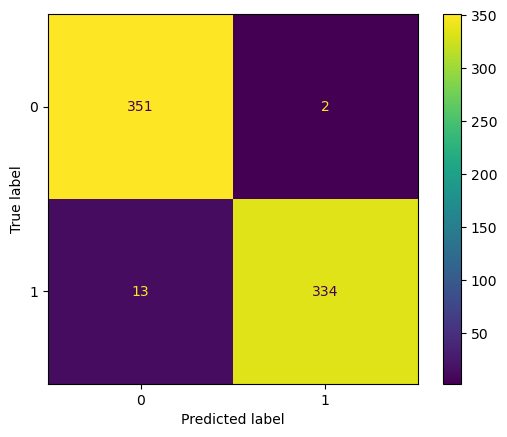

In [101]:
print('\n **************** Confusion Martix - Training Data **************** \n')
cm = confusion_matrix(y_train, y_pred_train, labels=svm_classifier.classes_)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show();

In [102]:
tn, fp, fn, tp = cm.ravel()

print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Positive: {tp}")

True Negative: 351
False Positive: 2
False Negative: 13
True Positive: 334


In [103]:
print('\n **************** Classification Report - Training Data **************** \n')
print(classification_report(y_test, y_pred_test))


 **************** Classification Report - Training Data **************** 

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       147
           1       0.85      0.77      0.81       153

    accuracy                           0.81       300
   macro avg       0.82      0.81      0.81       300
weighted avg       0.82      0.81      0.81       300




 **************** Confusion Martix - Training Data **************** 



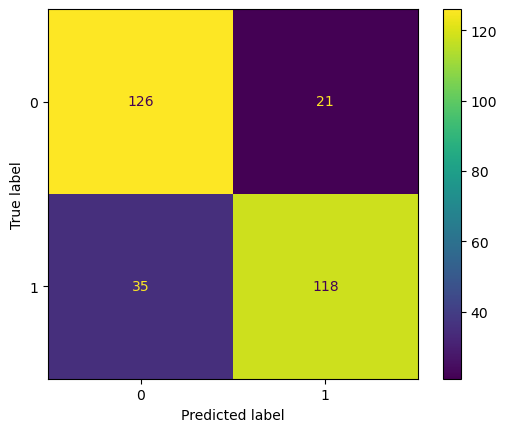

In [104]:
print('\n **************** Confusion Martix - Training Data **************** \n')
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show();